# Figure 3 — Directed evolution of light-sensitive AraC S170 AsLOV2 variants using Protein On/Off Gene Optimization using PANCE (POGO-PANCE)


This notebook reproduces **Figure 3** from the main manuscript.
---

### Figure Summary

<div style="text-indent:-2em; padding-left:2em"><strong>(A)</strong> Overview of POGO-PANCE Evolution of AraC R2 and R5 with S170 LOV inserted</div>  
<div style="text-indent:-2em; padding-left:2em"><strong>(B)</strong> Positional enrichment data from nanopore sequencing from the final day of each evolution regime, showing which residues are overrepresented in the phage population as being different from the reference, AraC R2 and R5 s170 LOV</div>  
<div style="text-indent:-2em; padding-left:2em"><strong>(C)</strong> Positional enrichment data from nanopore sequencing from one evolution regime over time, showing which residues are overrepresented in the phage population as being different from the reference, AraC R2 s170 LOV. Secondary structure is shown above.</div>  
<div style="text-indent:-2em; padding-left:2em"><strong>(D)</strong> Enrichment data from the positive selection days in F mapped onto a 3D Alphafold3 structure of AraC S170 LOV WT</div>

## Notebook Setup
----------------------------

Run the following cell to import all required libraries, define plotting settings, and configure the environment for data analysis and visualization.

In [1]:
# --- Import necessary modules ---
import os
import sys
os.chdir("..")
import json
import pickle as pkl
from importlib import reload
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import scipy
from Bio import SeqIO
from Bio.SeqIO import QualityIO
from utils import dna_rev_comp, translate_dna2aa
from scripts.preprocessing_functions import *
from scripts.plotting import *
from scripts.Illumina_functions import *
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# ======================== PLOTTING SETTINGS ========================

# --- Custom color map for mutation visualization ---
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
], N=256)

# --- Seaborn theme configuration ---
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1
}
sns.set_theme(context="paper", style='ticks', palette="Greys_r", rc=custom_params)

# --- General matplotlib settings ---
fs = 8  # font size
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    'font.family': 'Avenir Next',
    'font.weight': 'demi', 
    'font.size': fs,
    'text.color': '#231F20',
    'axes.labelcolor': '#231F20',
    'xtick.color': '#231F20',
    'ytick.color': '#231F20',
    'axes.edgecolor': '#231F20',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'pdf.fonttype': 42,
    'text.usetex': False
})
sns.set_context("paper", rc={
    "font.size": fs,
    "axes.titlesize": fs + 1,
    "axes.labelsize": fs,
    "axes.linewidth": 1,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "legend.title_fontsize": fs + 1
})

# ======================== LAYOUT PARAMETERS ========================

# --- Pre-defined figure dimensions for multi-panel plots ---
hi = 10.5 * 0.75
wi3 = 2.24
wi2 = 4.76
wi1 = 7.24
nr = 5

# --- Utility for shortening sample names ---
short_fn = np.vectorize(lambda x: x[:5])

## Figure 3A: Overview of POGO-PANCE Evolution of AraC R2 and R5 with S170 LOV inserted
----------------------------
 Summary of AraC-LOV evolution campaigns. Mutagenized phage libraries encoding AraC-R2-LOV or AraC-R5-LOV (characterized in Fig. S4C,D and Fig. S5A,B) were subjected to iterative rounds of positive and negative selection under alternating light and dark conditions. Three selection strategies were tested, each performed in duplicate phage pools. Phage titers for each day of selection are shown in Fig. S5C,D.

![Alt Text](/Volumes/ag-niopek/Niopek_Lab/8_Data/1_Nanopore/DMS_analysis/figure_notebooks/figure_illustrations/Figure_3A.png)

## Figure 3B: Positional enrichment data from nanopore sequencing from the final day of each evolution regime, showing which residues are overrepresented in the phage population as being different from the reference, AraC R2 and R5 s170 LOV.
----------------------------

Endpoint positional enrichment analysis of mutations across evolved variants. Mutation frequencies at each amino acid position in the AraC-LOV sequence were quantified by Nanopore sequencing. Enrichment values are displayed from `0` to `0.25`, with residues exceeding `0.25` shaded in <span style="color: yellow"><b>yellow</b></span>. Position R38 was excluded from the analysis due to consistent systematic errors observed in Nanopore sequencing. Co-occurrence enrichment analysis of individual phage populations is provided in Figure S7.

Total mutation enrichment from the Nanopore_P0109 dataset is shown, representing sequencing of final-day samples from various POGO cycle pools.

Only positions with a mutation rate `≥10%` in at least one pool are included. 

The data underlying this visualization was generated from preprocessed reads. Initial processing steps—including quality filtering, alignment, and correction of frame-disrupting indels introduced by Nanopore sequencing errors—were carried out using the scripts `Nanopore_read_filtering.py`, `Nanopore_alignment.py`, and `Nanopore_quality_control.py`. Alternatively, the complete workflow mentioned above can be executed via the shell script `Nanopore_filtering_alignment_processing.sh`, which sequentially integrates all these steps.

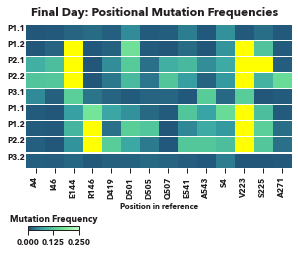

In [2]:
enrichments = {}
annots_WT = ['M0', 'S1', 'A2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'R146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'A152', 'I153', 'N154', 'L155', 'L156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'R251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']
barcodes = ["barcode01", "barcode02", "barcode03" , "barcode04", "barcode05", "barcode06", "barcode07", "barcode08", "barcode09"]
data_folder = "Nanopore_P0109"
quality = 20
data_type = 'AA'

# --- Load enrichment data for each barcode ---
for barcode in barcodes:
    araclov2_enr = pd.read_csv(f"/Volumes/ag-niopek/Niopek_Lab/8_Data/1_Nanopore/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
    total_enrichment = araclov2_enr.iloc[:-1,:].sum()
    enrichments[barcode] = araclov2_enr

# --- Identify positions with high mutation frequency ---
mut_rate_filter_treshold = 0.1

high_mut_positions = []

# --- Load enrichment data for each barcode ---
for cyclename, enrichment in enrichments.items():
    total_enrichment = enrichment.iloc[:-1,:].sum()
    high_mut_pos = [idx for idx, mut_rate in enumerate(total_enrichment) if mut_rate > mut_rate_filter_treshold]
    high_mut_positions.extend(high_mut_pos)

# --- Clean and annotate list of high-mutation positions ---
all_high_mut_positions = list(sorted(set(high_mut_positions))) 
all_high_mut_positions = [pos for pos in all_high_mut_positions if pos !=38]
all_high_mut_annots = [annots_WT[i] for i in all_high_mut_positions]


# --- Create heatmap figure layout ---
fig, axes = plt.subplots(9, figsize = (wi2,hi/3))
fig.subplots_adjust(hspace=0.1)
fig.suptitle("Final Day: Positional Mutation Frequencies", fontsize=12, y=0.98)

for idx, barcode in enumerate(barcodes): 
    plot_df = enrichments[barcode].copy()
    
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T
    plot_df = plot_df.iloc[:,all_high_mut_positions]

    my_cmap = custom_cmap
    my_cmap.set_over('Yellow')
    annotations = all_high_mut_annots

    sns.heatmap(plot_df, xticklabels=annotations if idx == 8 else False, ax = axes[idx], cmap = my_cmap, vmax=0.25, cbar = False, yticklabels=False, cbar_kws={"pad" : 0.02}, linewidths = 0)
    yticklabels = ["P1.1", "P1.2", "P2.1", "P2.2", "P3.1", "P1.1", "P1.2", "P2.2", "P3.2"]
    axes[idx].set_ylabel(yticklabels[idx], rotation=0, labelpad=10, fontsize=8)

    if idx == 8: 
        axes[idx].set_xlabel("Position in reference")
        axes[idx].set_xticklabels(annotations, rotation = 90)   

cbar_ax = fig.add_axes([0.13, -0.20, 0.15, 0.02])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation="horizontal")
cbar.set_label("Mutation Frequency", fontsize=9, labelpad=4)
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.set_ticks([0.0, 0.125, 0.25])
cbar.ax.tick_params(labelsize=8)

plt.show()

# plt.savefig(f"final_output/{data_folder}/POGO_end_days_highly_enriched_regions.pdf", bbox_inches = "tight", dpi = 600)
# plt.savefig(f"final_output/{data_folder}/POGO_end_days_highly_enriched_regions.png", bbox_inches = "tight")

## Figure 3C: Positional enrichment data from nanopore sequencing from one evolution regime over time, showing which residues are overrepresented in the phage population as being different from the reference, AraC R2 s170 LOV.
----------------------------

 Stepwise mutation enrichment during the R2-LOV P1.2 evolution campaign. Mutation frequencies at each amino acid position in the AraC-LOV sequence were quantified by Nanopore sequencing. Enrichment values are displayed from `0` to `0.25`, with residues exceeding `0.25` shaded in <span style="color: yellow"><b>yellow</b></span>. Secondary structure annotations for AraC S170-AsLOV2 are shown above (derived from InterPro and PSIPRED).

Total mutation enrichment from the Nanopore_P0109 dataset is shown, representing sequencing of final-day samples from various POGO cycle pools.


The data underlying this visualization was generated from preprocessed reads. Initial processing steps—including quality filtering, alignment, and correction of frame-disrupting indels introduced by Nanopore sequencing errors—were carried out using the scripts `Nanopore_read_filtering.py`, `Nanopore_alignment.py`, and `Nanopore_quality_control.py`. Alternatively, the complete workflow can be executed via the shell script `Nanopore_filtering_alignment_processing.sh`, which sequentially integrates all these steps.

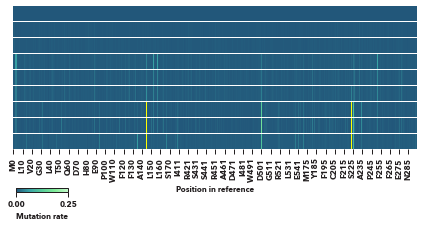

In [3]:
annots_R2 = ['M0', 'S1', 'A2', 'K3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'L146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'T152', 'I153', 'N154', 'L155', 'L156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'L251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']
barcodes = ["barcode01", "barcode02", "barcode04", "barcode05", "barcode06", "barcode08", "barcode09", "barcode10", "barcode12"]
enrichments = {}
data_folder = "Nanopore_P0115"

annots = annots_R2
total_enrichments = pd.DataFrame(index = barcodes, columns = annots)

# --- Load enrichment data and compute total enrichment per barcode ---
for barcode in barcodes:
    araclov2_enr = pd.read_csv(f"final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
    total_enrichment = araclov2_enr.iloc[:-1,:].sum()
    total_enrichments.loc[barcode] = total_enrichment
    enrichments[barcode] = araclov2_enr

# --- Subtract baseline enrichment from barcode01 to remove systematic Nanopore errors ---
baseline_enr = enrichments["barcode01"]

for key, enrichment_df in enrichments.items(): 
    enrichments[key] = enrichments[key] - baseline_enr


# --- Identify top 5% most variable positions ---
vars = total_enrichments.var()
quantile_threshold = np.percentile(vars, 95)
top_indices = [i for i, var in enumerate(vars) if var >= quantile_threshold]
annots_top_var = [annots[i] for i in top_indices]


# --- Create subplot layout for heatmaps ---
fig, axes = plt.subplots(9, figsize = (wi1,hi/3))
fig.subplots_adjust(hspace=0.1)

for idx, barcode in enumerate(barcodes): 

    plot_df = enrichments[barcode].copy()
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T
    my_cmap = plt.get_cmap(custom_cmap).copy()
    my_cmap.set_over('yellow')
    annotations = annots_R2 

    sns.heatmap(plot_df, xticklabels=annotations if idx  ==8 else False, ax = axes[idx], cmap = my_cmap, vmax=0.25, cbar = False, yticklabels=False, cbar_kws={"pad" : 0.02} )

    if idx == 8: 
        axes[idx].set_xlabel("Position in reference")
        axes[idx].set_xticks(list(range(0, len(annotations), 10)))
        axes[idx].set_xticklabels(annotations[::10])

cbar_ax = fig.add_axes([0.13, -0.1, 0.1, 0.02])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("Mutation rate")
cbar.set_ticks([0.0, 0.25])

# plt.savefig(f"final_output/{data_folder}/POGO_temporal_data_complete_region_bc01substr.pdf", bbox_inches = "tight", dpi = 600)
# plt.savefig(f"final_output/{data_folder}/POGO_temporal_data_complete_region_bc01substr.png", bbox_inches = "tight", dpi = 600)

plt.show()

## Figure 3D: Enrichment data from the positive selection days in F mapped onto a 3D Alphafold3 structure of AraC S170 LOV WT.
----------------------------
Structural mapping of enriched residues in AraC S170-AsLOV2 during R2-LOV P1.2 evolution. Mutation enrichment after each positive selection cycle is projected onto the protein structure. Pre-existing R2 mutations are marked in blue. Enrichment values are displayed from `0` to `0.10`, with residues exceeding `0.10` shaded in <span style="color:#6E1238"><b>deep burgundy</b></span>. For the final day, two views are shown, rotated 180°, and residues exceeding `0.10` are annotated.

To generate this visualization, position-wise enrichment values from the `Nanopore_P0115` dataset were mapped onto the LOV2 domain structure using the script `impose_enrichment_on_pymol.py`, which outputs a PyMOL-compatible .pml file. Final residue coloring was performed in PyMOL.

All `.pml` files used to generate these structural views are available in the repository under `scripts/pymol`.

![Alt Text](/Volumes/ag-niopek/Niopek_Lab/8_Data/1_Nanopore/DMS_analysis/figure_notebooks/figure_illustrations/Figure_3D.png)